In [1]:
import os
import urllib.request
import re
import os
import urllib.request
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import urllib.request
import re
! pip3 install tiktoken
import tiktoken
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Model

In [2]:
class CustomLayerNorm(nn.Module):
    """Layer Normalization with learnable parameters using torch primitives"""
    def __init__(self, features_dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features_dim))  # Scale parameter
        self.beta = nn.Parameter(torch.zeros(features_dim))  # Shift parameter
        self.epsilon = 1e-5

    def forward(self, x):
        # Ensure input is 3D: [batch_size, seq_len, features_dim]
        if x.dim() != 3:
            raise ValueError(f"Expected 3D input (got {x.dim()}D)")

        # Calculate statistics over the feature dimension
        feature_dim = x.size(-1)
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)

        # Normalize and apply learnable parameters
        x_normalized = (x - mean) / torch.sqrt(variance + self.epsilon)
        return self.gamma * x_normalized + self.beta

class ExactGELU(nn.Module):
    """Gaussian Error Linear Unit activation (GELU) using exact formulation"""
    def forward(self, x):
        return 0.5 * x * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))

class FeedForwardNetwork(nn.Module):
    """Transformer position-wise feed-forward network with expansion factor"""
    def __init__(self, config):
        super().__init__()
        hidden_dim = 4 * config["emb_dim"]

        self.net = nn.Sequential(
            nn.Linear(config["emb_dim"], hidden_dim),
            ExactGELU(),
            nn.Linear(hidden_dim, config["emb_dim"])
        )

    def forward(self, x):
        return self.net(x)

class TransformerLayer(nn.Module):
    """Transformer block with pre-normalization and residual connections"""
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadSelfAttention(
            embed_dim=config["emb_dim"],
            context_length=config["context_length"],
            num_heads=config["n_heads"],
            dropout=config["drop_rate"],
            qkv_bias=config["qkv_bias"]
        )
        self.ffn = FeedForwardNetwork(config)
        self.attention_norm = CustomLayerNorm(config["emb_dim"])
        self.ffn_norm = CustomLayerNorm(config["emb_dim"])
        self.residual_dropout = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # Attention sublayer
        x_attn = self.attention_norm(x)
        x = x + self.residual_dropout(self.attention(x_attn))

        # Feedforward sublayer
        x_ffn = self.ffn_norm(x)
        x = x + self.residual_dropout(self.ffn(x_ffn))
        return x

class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention mechanism with causal masking"""
    def __init__(self, embed_dim, context_length, num_heads, dropout, qkv_bias):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embed dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale_factor = self.head_dim ** -0.5

        # Projection matrices for queries, keys, values
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=qkv_bias)

        # Output projection and regularization
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)

        # Causal mask (buffer for efficient reuse)
        self.register_buffer("causal_mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Project input to query/key/value
        q = self.q_proj(x)  # [B, T, E]
        k = self.k_proj(x)
        v = self.v_proj(x)

        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale_factor  # [B, H, T, T]

        # Apply causal masking
        causal_mask = self.causal_mask[:seq_len, :seq_len]
        attn_scores.masked_fill_(causal_mask, float('-inf'))

        # Normalize and dropout
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        # Compute context vectors
        context = attn_weights @ v  # [B, H, T, D]
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        # Final projection
        return self.out_proj(context)

In [3]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerLayer(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = CustomLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### DATA

In [4]:
# Harry Potter Data
file_name_harrypotter = "/content/drive/My Drive/LLM course/LLM pretraining/Harry_Potter_all_books_preprocessed.txt"
with open(file_name_harrypotter, "r", encoding="utf-8") as f:
    raw_text = f.read().replace(" .", ". ")
# print(raw_text[-1000:])

In [5]:
# The Verdict Data
# if not os.path.exists("the-verdict.txt"):
#     url = ("https://raw.githubusercontent.com/rasbt/"
#            "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
#            "the-verdict.txt")
#     file_path = "the-verdict.txt"
#     urllib.request.urlretrieve(url, file_path)
# with open("the-verdict.txt", "r", encoding="utf-8") as f:
#     raw_text = f.read()
# print('raw_text', raw_text)

In [7]:
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

### Helper training functions

In [8]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special = {"<|endoftext|>"})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

def generate_text_simple(model, idx, max_new_tokens, context_size):
  # model : the GPTModel
  # idx : [batch, n_tokens]
  for _ in range(max_new_tokens):
    # crop current context if it exceed the context size
    idx_cond = idx[:, -context_size:]

    # Get predictions
    with torch.no_grad():
      logits = model(idx_cond)

    # Focus only on the last time step: (batch_size, n_tokens, vocab_size) => (batch_size, vocab_size)
    logits = logits[:, -1, :]

    # Apply softmax
    probas = torch.softmax(logits, dim = -1) # (batch_size, vocab_size)

    # Get the ids with the highest probability
    idx_next = torch.argmax(probas, dim = -1, keepdim = True) # (batch_size, 1)

    # Append sampled index into the running sequence
    idx = torch.cat((idx, idx_next), dim = 1) # (batch, n_tokens + 1)
  return idx

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [9]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    torch.save(model.state_dict(), '/content/drive/My Drive/LLM course/LLM pretraining/model.pth')

    return train_losses, val_losses, track_tokens_seen

### Training

In [10]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

train_loader = create_dataloader(
    train_data,
    batch_size=16,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=16,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)
print(f"Train loader has {len(train_loader)} batches")
print(f"Validation loader has {len(val_loader)} batches")

Train loader has 285 batches
Validation loader has 32 batches


Ep 1 (Step 000000): Train loss 9.962, Val loss 9.918
Ep 1 (Step 000005): Train loss 8.303, Val loss 8.302
Ep 1 (Step 000010): Train loss 7.383, Val loss 7.390
Ep 1 (Step 000015): Train loss 7.172, Val loss 7.196
Ep 1 (Step 000020): Train loss 7.198, Val loss 7.223
Ep 1 (Step 000025): Train loss 7.132, Val loss 7.206
Ep 1 (Step 000030): Train loss 7.077, Val loss 7.104
Ep 1 (Step 000035): Train loss 6.923, Val loss 7.021
Ep 1 (Step 000040): Train loss 6.854, Val loss 6.938
Ep 1 (Step 000045): Train loss 6.738, Val loss 6.865
Ep 1 (Step 000050): Train loss 6.720, Val loss 6.795
Ep 1 (Step 000055): Train loss 6.689, Val loss 6.726
Ep 1 (Step 000060): Train loss 6.554, Val loss 6.656
Ep 1 (Step 000065): Train loss 6.480, Val loss 6.604
Ep 1 (Step 000070): Train loss 6.366, Val loss 6.536
Ep 1 (Step 000075): Train loss 6.353, Val loss 6.472
Ep 1 (Step 000080): Train loss 6.255, Val loss 6.416
Ep 1 (Step 000085): Train loss 6.201, Val loss 6.377
Ep 1 (Step 000090): Train loss 6.097, Val loss

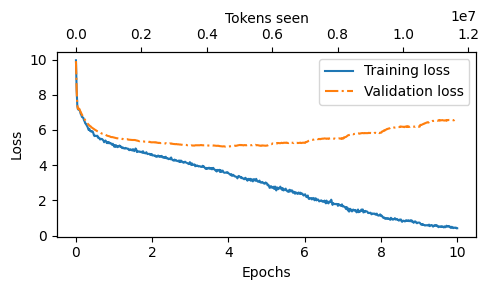

Training completed in 85.21 minutes.


In [11]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()
torch.manual_seed(123)

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Model
model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(torch.load('/content/drive/My Drive/LLM course/LLM pretraining/model.pth'))
model.to(device)

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# Train the model
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs = num_epochs, eval_freq = 5, eval_iter = 5,
    start_context = "He went to the", tokenizer = tiktoken.get_encoding("gpt2")
)

# Plot the losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, tokens_seen[-1], len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

# Print execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

### Testing with sample text

In [14]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model's state_dict
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load('/content/drive/My Drive/LLM course/LLM pretraining/simple_nn_model_state_dict.pth'))
model.to(device)

# Create tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Start context
start_context = "Hermione is going to the"

generate_and_print_sample(
    model, tokenizer, device, start_context
)


Hermione is going to the Leaky Cauldron where is Hermione ?Ron demanded. Harry looked up at the window. Hermione looked around at him. Hermione ?Hermione whispered. You didnt hear her ?I dont think Im really up at the top of the group said Harry.
